## Assignment 3: Vision Transformer and Contrastive Representation Learning

In this assignment, first, you are to implement [Vision Transformer](https://arxiv.org/pdf/2010.11929v2.pdf) (ViT) for image recognition. Then, you are utilize the implemented ViT to train a model using [Contrastive Representation Learning](https://arxiv.org/pdf/1503.03832.pdf), i.e. Triplet Loss.

### Submission Guidelines
The assignment codebase is split into two files. `vit_model.py` and `assignment3.ipynb`. In `vit_model.py`, incomplete codes for ViT and embedding model are provided, while in `assignment3.ipynb`, incomplete codes to iterate [FashionMNIST dataset](https://github.com/zalandoresearch/fashion-mnist) and initiate training and testing are provided in blocks. You are to complete the missing codeblock (Marked with comments and #TODO signs) and train the embedding representation model.

In addition to PyTorch, [pytorch-metric-learning](https://github.com/KevinMusgrave/pytorch-metric-learning) is needed to help with the implementation of contrastive representation learning. You are strongly encouraged to go through the [README of the repo](https://github.com/KevinMusgrave/pytorch-metric-learning/blob/master/README.md), which contains the basic usage of the package. You are also strongly encouraged to study the example notebooks provided within the repo, at your own pace.

To submit this assignment for grading, you must submit a compressed zipfile as `Assignment3_{YourCCID}.zip`, with three files inside: `vit_model.py`, `assignment3.ipynb`, and your trained embedding model as `vit_embeds.pt`.

### Collaboration Policy
This must be your own work. Do not share or look at the code of other students (whether they are inside or outside the class). Do not copy the code from the Internet, other than referring [PyTorch's official tutorials](https://pytorch.org/tutorials/), or the examples provided within [pytorch-metric-learning repo](https://github.com/KevinMusgrave/pytorch-metric-learning/tree/master/examples). You can talk to others in the class about solution ideas (but detailed enough that you are verbally sharing, hearing or seeing the code). You must cite whom you talked with in the comments of your programs.

In [26]:
# NOTE: Make sure the external packages are installed in Colab
!pip install pytorch-metric-learning
!pip install faiss-gpu
!pip install matplotlib tqdm


  Using cached faiss-gpu-1.7.1.post2.tar.gz (40 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz (from https://pypi.org/simple/faiss-gpu/): Requested faiss-cpu from https://files.pythonhosted.org/packages/17/76/47d0cc8161f4bf988583a2839bb1e56baf09d6b80cfa472b9eba4d5f543b/faiss-gpu-1.7.1.post2.tar.gz has inconsistent name: expected 'faiss-gpu', but metadata has 'faiss-cpu'
  Using cached faiss-gpu-1.7.1.post1.tar.gz (41 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Discarding https://files.pythonhosted.org/packages/39/8d/b62bc92c8dd4b2a99d4a06b8804280f6445748b6d698eabb037e111080c7/faiss-gpu-1.7.1.post1.tar.gz (from https://pypi.org/simple/faiss-gpu/): Requested faiss-cpu from https://files.pythonhosted.org/packages/39/8d/b62bc9

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      D:\Anaconda\envs\venvpy311\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
      running egg_info
      creating C:\Users\shiya\AppData\Local\Temp\pip-pip-egg-info-jqx3cxt8\faiss_cpu.egg-info
      writing C:\Users\shiya\AppData\Local\Temp\pip-pip-egg-info-jqx3cxt8\faiss_cpu.egg-info\PKG-INFO
      writing dependency_links to C:\Users\shiya\AppData\Local\

In [35]:
# Necessary imports for this assignment
# NOTE: DO NOT MODIFY UNLESS NECESSARY
import tqdm
import torch
import numpy as np
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop, CenterCrop
import matplotlib.pyplot as plt
from pytorch_metric_learning import miners, losses, distances
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


In [8]:
# Google Colab Patch
use_colab = True
'''
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    import sys
    # ----------------------------------------
    dir = "/content/drive/MyDrive/Cmput328/assignment3"    # TODO: MODIFY THIS TO INDICATE THE PARENT FOLDER OF YOUR vit_model.py file
    # ----------------------------------------
    sys.path.append(dir)
'''
from vit_model import *

In [28]:
# Hyperparameters
# NOTE: Feel free to add & modify hyperparameters if needed
num_epochs = 50
batch_size = 512
weight_decay = 1e-4
lr = None       # TODO: Use appropriate LR with LR scheduler

# ViT specifics
image_size = 28
in_channels = 1
patch_size = 4
hidden_size = 64
layers = 6
heads = 8
embed_size = 64

# Contrastive Learning specifics
margin = 0.2

### Part 1: Data Augmentation

For the dataset, we will use the FashionMNIST dataset. For implmentation, you are explore the usage of different [data augmentation](https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_illustrations.html) techniques.

**(1 out of 8)** You are to use at least 2 different types of data augmentation techniques (e.g. RandomHorizontalFlip) for training.

In [11]:
# Load FashionMNIST dataset
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(classes)

tfm_train = Compose([
    # TODO: Add your data augmentation HERE
    # ####################
    RandomHorizontalFlip(p=0.5),
    RandomRotation(degrees=10),  # Rotating the image by a maximum of 10 degrees



    # ####################
    ToTensor(),
    Normalize((0.5, ), (0.5, )),
    ])

tfm_test = Compose([
    ToTensor(),
    Normalize((0.5, ), (0.5, )),
    ])

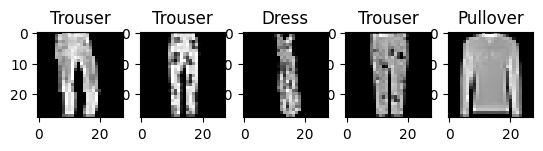

In [12]:
# NOTE: Inspect your data augmentation
def inverse_transform(
    img_tensor: torch.Tensor,
    ) -> np.ndarray:
    """Given a preprocessed image tensor, revert the normalization process and
    convert the tensor back to a numpy image.
    """
    inv_normalize = Normalize(mean=(-0.5/0.5, ), std=(1/0.5, ))
    img_tensor = inv_normalize(img_tensor).permute(1, 2, 0)
    img = np.uint8(255 * img_tensor.numpy())
    return img

# Get some random training images
n_imgs = 5
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tfm_train)
indices = np.random.randint(0, len(dataset), size=(n_imgs, ))

# Visualize with matplotlib
for i, idx in enumerate(indices):
    img_tensor, label = dataset[idx]
    img = inverse_transform(img_tensor)
    plt.subplot(1, n_imgs, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(classes[label])

plt.show()

### Part 2: Vision Transformer
**(2 out of 8)** For Part 1, you are to finish the implmentation of ViT, following the discussed lab instructions. Incomplete codes are provided in file `vit_model.py`.

A `check_vit.py` test script is provided to inspect the correctness of your implementations. Make sure not to modify any code in the provided test script.

Additionally, the code to train a classifier is provided below. If your ViT implementation is correct, a trained model should reach 88% accuracy and above with no issue.

In [13]:
# Train a Classifier
# -----

def train_classification_model():
    # Base ViT
    lr = 0.001  # Learning rate
    weight_decay = 0.0001  # L2 regularization coefficient
    num_epochs = 30
    vit_model = ViT(
        image_size=image_size,
        patch_size=patch_size,
        num_channels=in_channels,
        hidden_size=hidden_size,
        layers=layers,
        heads=heads)

    # Classifier
    model_classifier = ClassificationHead(hidden_size=vit_model.hidden_size, num_classes=num_classes)
    if torch.cuda.is_available():
        vit_model = vit_model.cuda()
        model_classifier = model_classifier.cuda()

    # Use cross entropy
    criterion = nn.CrossEntropyLoss()

    # Specify optimizer
    parameters = list(vit_model.parameters()) + list(model_classifier.parameters())
    optimizer = torch.optim.AdamW(
        parameters,
        lr=lr, weight_decay=weight_decay)

    # Evaluate at the end of each epoch
    best_acc = 0.0

    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(train_loader):
            vit_model.train()
            model_classifier.train()

            if torch.cuda.is_available():
                x = x.cuda()
                labels = labels.cuda()

            # Forward pass
            feats = vit_model(x)
            outputs = model_classifier(feats)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # NOTE: Show train loss at the end of epoch
            # Feel free to modify this to log more steps
            if (i+1) % len(train_loader) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        # Evaluate at the end
        test_acc = test_classification_model(vit_model, model_classifier)
        if test_acc > best_acc:
            best_acc = test_acc
            state_dict = {
                "classifier": model_classifier.state_dict(),
                "vit": vit_model.state_dict(),
                "acc": best_acc,
            }
            torch.save(state_dict, "vit_classifier.pt")
            print("Best test acc:", best_acc)
        print()

def test_classification_model(
    vit_model: nn.Module,
    model_classifier: nn.Module,
    ):
    # Test the model
    vit_model.eval()
    model_classifier.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            feats = vit_model(images)
            outputs = model_classifier(feats)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy: {} %'.format(100 * correct / total))
    return correct / total

In [14]:
# NOTE: Uncomment this to test your ViT implementation

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tfm_train)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tfm_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_classification_model()

del train_dataset
del test_dataset

Epoch [1/30], Step [118/118], Loss: 0.7689
Test Accuracy: 76.34 %
Best test acc: 0.7634

Epoch [2/30], Step [118/118], Loss: 0.6753
Test Accuracy: 80.75 %
Best test acc: 0.8075

Epoch [3/30], Step [118/118], Loss: 0.6940
Test Accuracy: 81.1 %
Best test acc: 0.811

Epoch [4/30], Step [118/118], Loss: 0.6422
Test Accuracy: 81.82 %
Best test acc: 0.8182

Epoch [5/30], Step [118/118], Loss: 0.4043
Test Accuracy: 84.77 %
Best test acc: 0.8477

Epoch [6/30], Step [118/118], Loss: 0.4652
Test Accuracy: 84.7 %

Epoch [7/30], Step [118/118], Loss: 0.3894
Test Accuracy: 85.56 %
Best test acc: 0.8556

Epoch [8/30], Step [118/118], Loss: 0.3706
Test Accuracy: 85.48 %

Epoch [9/30], Step [118/118], Loss: 0.3640
Test Accuracy: 85.55 %

Epoch [10/30], Step [118/118], Loss: 0.3478
Test Accuracy: 86.46 %
Best test acc: 0.8646

Epoch [11/30], Step [118/118], Loss: 0.4394
Test Accuracy: 86.67 %
Best test acc: 0.8667

Epoch [12/30], Step [118/118], Loss: 0.3080
Test Accuracy: 86.16 %

Epoch [13/30], Step 

### Part 3: Contrastive Representation Learning
In this part, you are to use [PyTorch-Metric-Learning](https://github.com/KevinMusgrave/pytorch-metric-learning) to implement triplet loss and learn an embedding representation model with ViT. Quick tutorials and notebooks are available in the repo.

However, only a subset of data from the FashionMNIST training set (around 1/12) will be used to train the model. The code to subsample the full train dataset is provided in `sample_balanced_subset`. You must not modfiy the code in that block.

To pass this part, you are to reach **60%** and above in Precision@1 metric scoring on the full FashionMNIST test dataset with your trained embedding model. The final model must be submitted along with your notebook with logging outputs. The test function is provided in `evaluate_at_end_epoch`.

Furthermore, you are required to employ one of the learning rate schedulers, like [MultiStepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html#torch.optim.lr_scheduler.MultiStepLR), [Consine Annealing LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR). Or you can implement your own learning rate adjusting strategy, as a function to training iteration or epoch, using [LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR). The marking is distributed as follows:

- (2 out of 8) Complete `train_embedding_model`. Add your selected learning rate scheduler, and train your embedding model
- (0.5 out of 8) Complete `get_embeddings` to correctly perform inference with your embedding model.
- (1 out of 8) Attach the notebook with full training logs (do not clear your notebook outputs when finished running), and your trained model file with **60%** and above in Precision@1 metric scoring, as `vit_embeds.pt`.

In [29]:
# Sample a subset of training dataset
# NOTE: sample an even number of samples per class
# To migrate the problem of [class imbalancing]
# (https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data).
def sample_balanced_subset(
    train_dataset,
    n_samples_per_class: int = 50,
    n_classes: int = 10
    ):
    maps = {i: [] for i in range(n_classes)}
    for idx, (_, cls_idx) in enumerate(train_dataset):
        if len(maps[cls_idx]) < n_samples_per_class:
            maps[cls_idx].append(idx)

    indices = []
    for _, ind in maps.items():
        indices += ind

    train_subset = torch.utils.data.Subset(train_dataset, indices)
    print("Num. samples in subset:", len(train_subset))
    return train_subset

# Subsample a small subset from the full train dataset
full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=tfm_train)
train_dataset = sample_balanced_subset(full_train_dataset, n_samples_per_class=500)      # DO NOT MODIFY THIS CODE

# Full test set will still be used for testing
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=tfm_test)

Num. samples in subset: 5000


In [36]:
# Train an embedding model
# -----
import torch.optim as optim
def train_embedding_model(
    train_dataset,
    test_dataset,
    ):
    #########################
    # Finish Your Code HERE
    # #########################

    # Dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Evaluate model per epoch, and keep track of the model performance at that time
    best_prec = 0.0

    # Triplet Loss with Semi-hard triples & l2 distance
    # -------------------
    # TODO: Specify distance, objective function (triplet loss), and your miner to sample triplet pairs

    distance = distances.LpDistance(power=2)
    criterion = losses.TripletMarginLoss(margin=0.2, distance=distance)
    miner = miners.BatchHardMiner(distance=distance)#miners.DistanceWeightedMiner(distance=distance)#miners.SemiHardNegativeTripletMiner(distance=distance)#miners.BatchSemiHardMiner(distance=distance, type_of_triplets="semi-hard")        # Make sure to use "semihard" triplets
    #criterion = losses.TripletMarginLoss(margin=0.2, distance=distance)
    #miner = miners.SemiHardNegativeTripletMiner(distance=distance)        # "semihard" triplets

    # -------------------

    # Precision to test embedding quality
    accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)

    # Models to train
    # -------------------
    # TODO: Specify your model(s) correctly here
    # Don't forget to send them to cuda/gpu
    vit_model = ViT(
        image_size=image_size,
        patch_size=patch_size,
        num_channels=in_channels,
        hidden_size=hidden_size,
        layers=layers,
        heads=heads
    ).cuda()
    #model_embedding = nn.Sequential(nn.Linear(vit_model.hidden_size, embedding_size), nn.ReLU(), nn.Linear(embedding_size, embedding_size))
    #embedding_dim = 64
    #model_embedding = nn.Sequential(
     #   nn.Linear(vit_model.hidden_size, embedding_dim),
     #   nn.ReLU()
    #).cuda()
    model_embedding = LinearEmbeddingHead(hidden_size=hidden_size,embed_size=64).cuda()
    # -------------------

    # Specify optimizer
    # -------------------
    #parameters = None       # TODO: correctly specify the trainable parameters here

    #optimizer = None        # TODO: Specify your optimizer

    #scheduler = None        # TODO: Specify your LR scheduler
    #parameters = list(vit_model.parameters()) + list(model_embedding.parameters())
    #optimizer = optim.AdamW(parameters, lr=0.001, weight_decay=0.01)
    #scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)
    parameters = list(vit_model.parameters()) + list(model_embedding.parameters())
    #optimizer = torch.optim.AdamW(parameters, lr=0.0001, weight_decay=0.0001)
    #scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,5], gamma=0.1)  # Example scheduler
    #lr = 0.001,[5,10]
    optimizer = torch.optim.Adam(parameters, lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=10)



    # -------------------

    # Train loop
    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(train_loader):
            vit_model.train()
            model_embedding.train()

            if torch.cuda.is_available():
                x = x.cuda()
                labels = labels.cuda()

            # Forward pass
            # -------------------
            # TODO: Implement forward and backward pass
            # TODO: Correctly update your LR with your selected LR scheduler
            feats = vit_model(x)
            embeddings = model_embedding(feats)

            hard_triplets = miner(embeddings, labels)
            loss = criterion(embeddings, labels, hard_triplets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # -------------------

            # NOTE: Show train loss at the end of epoch
            # Feel free to modify this to log more steps
            if (i+1) % len(train_loader) == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        # Evaluate at the end
        best_prec = evaluate_at_end_epoch(vit_model, model_embedding, accuracy_calculator, best_prec, train_dataset, test_dataset)

    # #########################

def get_embeddings(
    x: torch.Tensor,
    vit_model: nn.Module,
    model_embedding: nn.Module,
    ) -> torch.Tensor:
    """Calculate embeddings for a batch of images.
    """
    #########################
    # Finish Your Code HERE
    # #########################
    # TODO: Correctly calculate x_embeds for a batch of
    # images x with shape (batch_size, 3, h, w)

    with torch.no_grad():
        vit_model.eval()
        model_embedding.eval()

        if torch.cuda.is_available():
            x = x.cuda()

        feats = vit_model(x)
        x_embeds = model_embedding(feats)


    #########################

    x_embeds = x_embeds.cpu()   # Cast to CPU
    x_embeds = torch.nn.functional.normalize(x_embeds, p=2, dim=1)      # Extra Step: Normalize the embeddings
    return x_embeds

def get_embeddings_over_dataset(
    dataset,
    vit_model: nn.Module,
    model_embedding: nn.Module,
    ):
    """Loop through a full dataset and return all embeddings.
    """
    # Create a loader on the go
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    X_embeds, Y = [], []
    for i, (x, y) in enumerate(tqdm.tqdm(loader)):
        x_embeds = get_embeddings(x, vit_model, model_embedding)
        X_embeds.append(x_embeds)
        Y.append(y)

    X_embeds = torch.cat(X_embeds, dim=0)
    Y = torch.cat(Y, dim=0)
    return X_embeds, Y

def test_embedding_model(
    vit_model: nn.Module,
    model_embedding: nn.Module,
    accuracy_calculator,
    train_dataset,
    test_dataset,
    ):
    # Test the model
    model_embedding.eval()

    X_embeds, Y = get_embeddings_over_dataset(train_dataset, vit_model, model_embedding)
    X_embeds_test, Y_test = get_embeddings_over_dataset(test_dataset, vit_model, model_embedding)
    accuracies = accuracy_calculator.get_accuracy(
        X_embeds_test, Y_test, X_embeds, Y, False
    )
    return accuracies["precision_at_1"]

def evaluate_at_end_epoch(
    vit_model: nn.Module,
    model_embedding: nn.Module,
    accuracy_calculator,
    best_prec: float,
    train_dataset,
    test_dataset,
    ):
    # Evaluate at the end
    prec = test_embedding_model(vit_model, model_embedding, accuracy_calculator, train_dataset, test_dataset)
    if prec > best_prec:
        best_prec = prec
        state_dict = {
            "embedding_head": model_embedding.state_dict(),
            "vit": vit_model.state_dict(),
            "precision@1": prec,
        }
        torch.save(state_dict, "vit_embeds.pt")
        print("Best Precision@1:", best_prec)
    print()
    return best_prec


In [37]:
# TODO: Uncomment this to train your embedding model
torch.cuda.empty_cache()    # Clean-up memory 1st
train_embedding_model(train_dataset, test_dataset)

NameError: name 'faiss' is not defined

### Part 4: Application
In the below examples, we perform inference with the trained embedding model using K-nearest neighbors.

In [33]:
torch.cuda.empty_cache()    # Clean-up memory 1st

# Load your trained model
# Base ViT
vit_model = ViT(
    image_size=image_size,
    patch_size=patch_size,
    num_channels=in_channels,
    hidden_size=hidden_size,
    layers=layers,
    heads=heads)

# Embedding head
model_embedding = LinearEmbeddingHead(hidden_size=vit_model.hidden_size, embed_size=embed_size)
if torch.cuda.is_available():
    vit_model = vit_model.cuda()
    model_embedding = model_embedding.cuda()

# Load saved checkpoint
checkpoint = torch.load("vit_embeds.pt")

vit_model.load_state_dict(checkpoint["vit"])

model_embedding.load_state_dict(checkpoint["embedding_head"])

FileNotFoundError: [Errno 2] No such file or directory: 'vit_embeds.pt'

To quickly infer K-nearest neighbors, we construct a small bank, where the (image, label) pairs in the bank are sampled from the training set.

In [129]:
# Sample a bank, which is a small subset of trainset
bank = sample_balanced_subset(train_dataset, n_samples_per_class=25)
X_bank_embeds, Y_bank = get_embeddings_over_dataset(bank, vit_model=vit_model, model_embedding=model_embedding)

Num. samples in subset: 250


100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Now, we perform the K-nearest neighbors, by comparing our sample against the embeddings in the bank.

**(0.5 out of 8)** You are to finish the implementation of the function `retrieve_topk_nearest_neighbors_l2`, in order to acquire the demoing visualizations.

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fb127dac0d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


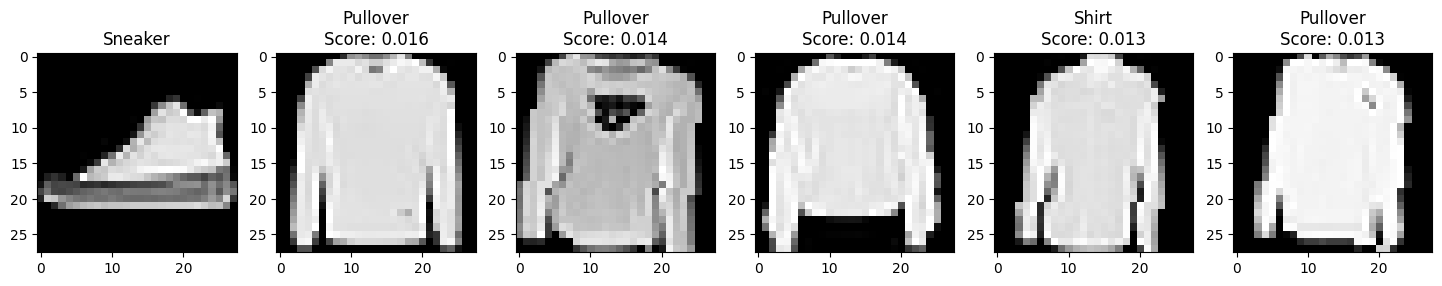

In [152]:
# Deep KNN
def retrieve_topk_nearest_neighbors_l2(
    query: torch.Tensor,
    ref: torch.Tensor,
    k: int = 5,
    ):
    """Calculate L2 distance between query and ref embeddings.
    Return the top-k scores and the indices of the top-k scores.
    """
    #########################
    # Finish Your Code HERE
    # #########################
    # TODO: Implement L2 distance and topk ops
    #distances = torch.norm(query - ref, dim=1)
    difference = torch.subtract(query, ref)
    distances = torch.norm(difference, dim=1)

    top_k_scores, indices = torch.topk(distances, k=k)



    # #########################

    return top_k_scores, indices

# Grab some samples in test set
dataiter = iter(test_loader)
X, Y = next(dataiter)
X_embeds = get_embeddings(X, vit_model=vit_model, model_embedding=model_embedding)

# One random sample
idx = np.random.randint(0, X.shape[0])
img, label, embed = X[idx], Y[idx], X_embeds[idx]

# Get top-k nearest samples
values, indices = retrieve_topk_nearest_neighbors_l2(embed.unsqueeze(0), X_bank_embeds)

# Visualize results
_, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(inverse_transform(img), cmap="gray")
axes[0].set_title(classes[label])
for i, ind in enumerate(indices):
    img_bank, label_bank = bank[ind]
    axes[i + 1].imshow(inverse_transform(img_bank), cmap="gray")
    axes[i + 1].set_title("{}\nScore: {:.3f}".format(classes[label_bank], values[i]))

The trained embedding model can also be used to train a new classifier.

The intuition behind **Transfer Learning**, and a referring tutorial can be seen [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

**(1 out of 8)** Complete your code to train a classification head only, using your trained ViT embedding model. But you should not modify your trained ViT model weights in your `train_classification_model_head_only` function.

A sample function to test with the classification head is provided, as `test_classification_model`.

In [159]:
# Train a Classifier
# -----
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
def train_classification_model_head_only(
    vit_model: nn.Module,
    train_dataset,
    test_dataset,
    num_epochs: int = 10,
    ):
    #########################
    # Finish Your Code HERE
    # #########################

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    #test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


    num_classes = 25
    # Classifier
    #model_classifier = nn.Linear(vit_model.hidden_size, num_classes).cuda() if torch.cuda.is_available() else nn.Linear(vit_model.hidden_size, num_classes)
    #model_classifier=KNeighborsClassifier(n_neighbors = k)
    vit_model = vit_model


    #criterion = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model_classifier.parameters(), lr=0.001)
    #best_acc = 0.0
    #model_classifier = nn.Linear(vit_model.hidden_size, num_classes).cuda() if torch.cuda.is_available() else nn.Linear(vit_model.hidden_size, num_classes)
    model_classifier = nn.Linear(vit_model.hidden_size, num_classes).cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model_classifier.parameters(), lr=0.001)
    best_acc = 0.0

    # Freeze the weights of vit_model during training
    for param in vit_model.parameters():
        param.requires_grad = False

    # Training loop
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            # Forward pass
            features = vit_model(images)
            outputs = model_classifier(features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Compute accuracy on the test dataset after every epoch
        acc = test_classification_model(vit_model, model_classifier)
        if acc > best_acc:
            best_acc = acc





    # #########################

    # You should return the weights of your trained model, and the classification score (accuracy)
    return {"acc": acc, "vit": vit_model.state_dict(), "classifier":model_classifier.state_dict()}

def test_classification_model(
    vit_model: nn.Module,
    model_classifier: nn.Module,
    ):
    # Test the model
    vit_model.eval()
    model_classifier.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            feats = vit_model(images)
            outputs = model_classifier(feats)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy: {} %'.format(100 * correct / total))
    return correct / total

In [160]:
# Train a deep classifier in 5 epochs
train_classification_model_head_only(vit_model, train_dataset, test_dataset)

Test Accuracy: 10.0 %
Test Accuracy: 10.08 %
Test Accuracy: 14.68 %
Test Accuracy: 10.85 %
Test Accuracy: 12.76 %
Test Accuracy: 17.49 %
Test Accuracy: 10.0 %
Test Accuracy: 16.92 %
Test Accuracy: 17.29 %
Test Accuracy: 10.24 %


{'acc': 0.1024,
 'vit': OrderedDict([('patch_embed.projection.weight',
               tensor([[[[-0.1835, -0.1979, -0.0795,  0.1583],
                         [ 0.2314, -0.1939, -0.1575,  0.1412],
                         [-0.0342, -0.0938,  0.0675,  0.0856],
                         [ 0.1280, -0.0883,  0.0431,  0.0818]]],
               
               
                       [[[ 0.1072,  0.0541,  0.1320, -0.1355],
                         [-0.1904, -0.1812,  0.1187, -0.0236],
                         [ 0.0215,  0.0939,  0.0422,  0.1958],
                         [-0.1774, -0.1203,  0.0632, -0.0544]]],
               
               
                       [[[ 0.1177, -0.1040,  0.2073,  0.1897],
                         [-0.1212, -0.0025,  0.1663, -0.0704],
                         [ 0.1314, -0.0573,  0.2379, -0.2178],
                         [-0.0571, -0.0598,  0.1324, -0.1551]]],
               
               
                       ...,
               
               
           